# 터미널로 csv 파일 확인해 보기

In [3]:
data_dir = '/Volumes/MINDB/Luna16/'

## candidates.csv

- 551000개의 행이 존재하고 class 가 1인 경우 1,351개가 있다.

In [4]:
!wc -l /Volumes/MINDB/Luna16/candidates.csv

  551066 /Volumes/MINDB/Luna16/candidates.csv


In [5]:
!head /Volumes/MINDB/Luna16/candidates.csv

seriesuid,coordX,coordY,coordZ,class
1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860,-56.08,-67.85,-311.92,0
1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860,53.21,-244.41,-245.17,0
1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860,103.66,-121.8,-286.62,0
1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860,-33.66,-72.75,-308.41,0
1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860,-32.25,-85.36,-362.51,0
1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860,-26.65,-203.07,-165.07,0
1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860,-74.99,-114.79,-311.92,0
1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860,-16.14,-248.61,-239.55,0
1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860,135.89,-141.41,-252.2,0


In [6]:
!grep ',1$' /Volumes/MINDB/Luna16/candidates.csv | wc -l

       0


In [7]:
import pandas as pd

data = pd.read_csv(data_dir + 'candidates.csv')
data['class'].value_counts()

class
0    549714
1      1351
Name: count, dtype: int64

# 훈련 셋과 검증 셋

### annotation.csv 와 candidates.csv 데이터 비교

In [8]:
import pandas as pd

annotation = pd.read_csv(data_dir + 'annotations.csv')
candidates = pd.read_csv(data_dir + 'candidates.csv')

print(f'annotation shape : {annotation.shape}')
print(f'candidates shape : {candidates.shape}')

annotation shape : (1186, 5)
candidates shape : (551065, 5)


In [9]:
annotation.head()

,seriesuid,coordX,coordY,coordZ,diameter_mm
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-128.699421,-175.319272,-298.387506,5.651471
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,103.783651,-211.925149,-227.121250,4.224708
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...,69.639017,-140.944586,876.374496,5.786348
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,-24.013824,192.102405,-391.081276,8.143262
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,2.441547,172.464881,-405.493732,18.545150


In [10]:
sample_id = annotation['seriesuid'][2]
idx = annotation[annotation['seriesuid'] == sample_id].index
print(f'annotation infos : \n {sample_id} \n coordination shape : {annotation.iloc[idx,1] , annotation.iloc[idx,2], annotation.iloc[idx,3]} \n diameter_mm : {annotation.iloc[idx,-1]}')

annotation infos : 
 1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793540579077826395208 
 coordination shape : (2    69.639017
Name: coordX, dtype: float64, 2   -140.944586
Name: coordY, dtype: float64, 2    876.374496
Name: coordZ, dtype: float64) 
 diameter_mm : 2    5.786348
Name: diameter_mm, dtype: float64


In [11]:
idx = candidates[candidates['seriesuid'] == sample_id].index

candidates[(candidates['seriesuid'] == sample_id) * (candidates['class'] == 1)]
# print(f'candidates infos : \n {sample_id} \n coordination shape : {candidates.iloc[idx,1] , candidates.iloc[idx,2], candidates.iloc[idx,3]} \n diameter_mm : {candidates.iloc[idx,-1]}')


,seriesuid,coordX,coordY,coordZ,class
1303,1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...,70.19,-140.93,877.68,1


- 같은 sample_id 를 가지고 있는 환자의 annotaion 과 candidates 에서 두 좌표는 각각 직경 5.78 밀리미터이며, 정확하게 결절의 중심부를 나타내지만 두 좌표가 완벽하게 일치하진 않는다.
따라서 이와 같이 데이터가 불일치한 경우라면, 다룰 가치가 없는 것으로 판단하고 무시하는 것이 맞다.

In [12]:
from collections import namedtuple

CandidateInfoTuple = namedtuple(
    'CandidateInfoTuple',
    'isNodule_bool, diameter_mm, series_uid, center_xyz'
)

Candidate info list 는 결절의 상태와 결절의 직경, 그리고 순번과 중심점을 갖는다.

NoduleInfo Tuple 인스턴스 리스트를 만드는 함수는 인메모리 캐신 데코레이터를 사용하고 디스크 파일 경로를 얻는다.

In [18]:
import glob
import os

import pandas as pd

from functools import lru_cache

data_dir = '/Volumes/MINDB/Luna16'

@lru_cache(1)
def getCandidateInfoLisst(requireOnDisk_bool = True):
    mhd_list = glob.glob(data_dir + '/subset*/*.mhd')
    presentOnDisk_set = {os.path.split(p)[-1][:-4] for p in mhd_list}
    ## seriesID 만 추출 (확장자명 제외)

    diameter_dict = {}

    annotations = pd.read_csv(data_dir + '/annotations.csv')

    for idx in range(len(annotations)):
        series_uid = annotations.iloc[idx, 0]

        annotationCenter_xyz = tuple([float(x) for x in annotations.iloc[idx , 1:4]])
        annotationDiameter_mm = float(annotations.iloc[idx, 4])

        diameter_dict.setdefault(series_uid , []).append(
            (annotationCenter_xyz , annotationDiameter_mm)
        )

    candidateInfo_list = []

    candidates = pd.read_csv(data_dir + '/candidates.csv')

    for idx in range(len(candidates)):
        series_uid = candidates.iloc[idx, 0]

        if series_uid not in presentOnDisk_set and requireOnDisk_bool:
            continue

        isNodule_bool = bool(int(candidates.iloc[idx, 4]))
        candidateCenter_xyz = tuple([float(x) for x in candidates.iloc[idx, 1:4]])

        candidateDiameter_mm = 0.0
        # annotation 과 candidates 의 좌표 위치가 안맞는 부분을 수정하기 위해
        # 비슷한 좌표를 찾은 뒤 같다고 표시
        for annotation_tup in diameter_dict.get(series_uid, []):
            annotationCenter_xyz, annotationDiameter_mm = annotation_tup
            for i in range(3):
                delta_mm = abs(candidateCenter_xyz[i] - annotationCenter_xyz[i])
                if delta_mm > annotationDiameter_mm / 4:
                    break
                else:
                    candidateDiameter_mm == annotationDiameter_mm
                    break
            
        candidateInfo_list.append(CandidateInfoTuple(
            isNodule_bool,
            candidateDiameter_mm,
            series_uid,
            candidateCenter_xyz,
        ))

    candidateInfo_list.sort(reverse= True)
    return candidateInfo_list

data = getCandidateInfoLisst()

len(data)



KeyboardInterrupt: 

- 위의 방식으로 해봤더니 매우 느리다 뭔가 비효율적이게 짠게 틀림 없다....

In [19]:
import csv
import glob
import os

import pandas as pd

from functools import lru_cache

@lru_cache(1)
def getCandidateInfoList(requireOnDisk_bool=True):
    mhd_list = glob.glob(data_dir + '/subset*/*.mhd')
    presentOnDisk_set = {os.path.split(p)[-1][:-4] for p in mhd_list}

    diameter_dict = {}
    with open(data_dir + '/annotations.csv', "r") as f:
        for row in list(csv.reader(f))[1:]:
            series_uid = row[0]
            annotationCenter_xyz = tuple([float(x) for x in row[1:4]])
            annotationDiameter_mm = float(row[4])

            diameter_dict.setdefault(series_uid, []).append(
                (annotationCenter_xyz, annotationDiameter_mm)
            )

    candidateInfo_list = []
    with open(data_dir + '/candidates.csv', "r") as f:
        for row in list(csv.reader(f))[1:]:
            series_uid = row[0]

            if series_uid not in presentOnDisk_set and requireOnDisk_bool:
                continue

            isNodule_bool = bool(int(row[4]))
            candidateCenter_xyz = tuple([float(x) for x in row[1:4]])

            candidateDiameter_mm = 0.0
            for annotation_tup in diameter_dict.get(series_uid, []):
                annotationCenter_xyz, annotationDiameter_mm = annotation_tup
                for i in range(3):
                    delta_mm = abs(candidateCenter_xyz[i] - annotationCenter_xyz[i])
                    if delta_mm > annotationDiameter_mm / 4:
                        break
                    else:
                        candidateDiameter_mm = annotationDiameter_mm
                        break

            candidateInfo_list.append(CandidateInfoTuple(
                isNodule_bool,
                candidateDiameter_mm,
                series_uid,
                candidateCenter_xyz,
            ))

    candidateInfo_list.sort(reverse=True)
    return candidateInfo_list

data = getCandidateInfoList()

len(data)

551065

- 일부 데이터 파일은 파싱에 시간이 걸리므로 함수 호출 결과를 메모리에 캐시한다.

=> 앞으로 여러 장에 걸쳐 이 함수를 자주 호출하게 되므로 이런 방식은 꽤 유용하다.</br>
=> 인메모리나 온디스크 캐싱을 적절하게 사용하여 데이터 파이프라인 속도를 올려놓으면 훈련 속도의 상당한 개선으로 이어질 수 있다.

- requireOnDisk_bool 을 이용하여 디스크 상에서 시리즈 UID 가 발견되는 LUNA 데이터만 사용하고 이에 해당하는 엔트리만 CSV 파일에서 걸러 사용할 예정이다.

- 훈련 루프 단계에서 데이터의 일부만 실행할 수 있게 되면, 코드가 의도 대로 동작하는지 쉽게 검증할 수 있다.

- pandas 와 csv 의 차이점

- csv 모듈을 사용한 방법은 메모리 관리 측면에서 더 효율적이고, 큰 데이터 파일에 대해 더 나은 성능을 제공할 가능성이 높다.
- 하지만 pandas 를 사용하는 방식은 데이터 조작과 복잡한 데이터 처리에서 더 편리하고 강력하지만 시스템의 메모리 자원을 많이 소모할 수 있다.

In [ ]:
import numpy as np
import SimpleITK as sitk
import collections

XyzTuple = collections.namedtuple('XyzTuple', ['x','y','z'])


class Ct:
    def __init__(self, series_uid):
        mhd_path = glob.glob(
            '/Volumes/MINDB/Luna16/subset*/{}.mhd'.format(series_uid)
        )[0]

        ct_mhd = sitk.ReadImage(mhd_path)
        ct_a = np.array(sitk.GetArrayFromImage(ct_mhd), dtype = np.float32)

        ct_a.clip(-1000,1000, out = ct_a)
        # replace = True

        self.series_uid = series_uid
        self.hu_a = ct_a

        self.origin_xyz = XyzTuple(*ct_mhd.GetOrigin())


### 밀리미터를 복셀 주소로 변환하기

In [53]:
IrcTuple = collections.namedtuple('IrcTuple', ['index', 'row', 'col'])
XyzTuple = collections.namedtuple('XyzTuple', ['x','y','z'])

def irc2xyz(coord_irc, origin_xyz, vxSize_xyz, direction_a):
    cri_a = np.array(coord_irc)[::-1]
    origin_a = np.array(origin_xyz)
    vxSize_a = np.array(vxSize_xyz)
    coords_xyz = (direction_a @ (cri_a * vxSize_a)) + origin_a
    return XyzTuple(*coords_xyz)



### 데이터 샘플 예시 보기

In [59]:
import SimpleITK as sitk
import glob
data_dir = '/Volumes/MINDB/Luna16/'
mhd_path = glob.glob(
    data_dir + 'subset*/{}.mhd'.format()
)

IndexError: Replacement index 0 out of range for positional args tuple

In [78]:
import SimpleITK as sitk

mhd_path = glob.glob(data_dir + '/subset*/{}.mhd'.format(data[0][2]))
mhd_path[0]

ct_mhd = sitk.ReadImage(mhd_path[0])

XyzTuple(*ct_mhd.GetOrigin())

ct_mhd

<SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x12bda4030> >

In [79]:
import collections
XyzTuple = collections.namedtuple('XyzTuple', ['x','y','z'])

In [80]:
XyzTuple(*ct_mhd.GetOrigin())

XyzTuple(x=-212.199997, y=-210.0, z=-338.0)

In [81]:
ct_mhd.GetSpacing()

(0.8203120231628418, 0.8203120231628418, 2.5)

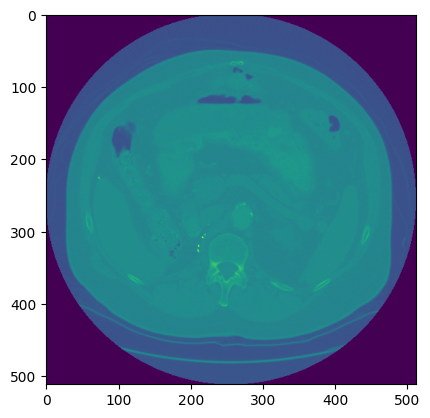

In [82]:
import numpy as np
import matplotlib.pyplot as plt

ct_a = np.array(sitk.GetArrayFromImage(ct_mhd), dtype = np.float32)

plt.imshow(ct_a[0])

In [86]:
ct_mhd['ITK']

('ITK_InputFilterName', 'ITK_original_direction', 'ITK_original_spacing')

## DataSet 만들기

In [69]:
import collections

IrcTuple = collections.namedtuple('Irctuple', ['index','row','col'])
XyzTuple = collections.namedtuple('Xyztuple', ['x','y','z'])

def xyz2irc(coord_xyz, origin_xyz, vxSize_xyz , direction_a):
    origin_a = np.array(origin_xyz)
    vxSize_a = np.array(vxSize_xyz)
    coord_a = np.array(coord_xyz)
    cri_a = ((coord_a - origin_a) @ np.linalg.inv(direction_a)) / vxSize_a
    cri_a = np.round(cri_a)
    return IrcTuple(int(cri_a[2]), int(cri_a[1]), int(cri_a[0]))

In [71]:
import copy
import logging
import torch
import glob
import functools

import SimpleITK as sitk

from torch.utils.data import Dataset

log = logging.getLogger()
log.setLevel(logging.INFO)

class Ct:
    def __init__(self,series_uid):
        mhd_path = glob.glob(
            data_dir + 'subset*/{}.mhd'.format(series_uid)
        )[0]

        ct_mhd = sitk.ReadImage(mhd_path)
        ct_a = np.array(sitk.GetArrayFromImage(ct_mhd), dtype=np.float32)

        ct_a.clip(-1000,1000,ct_a)

        self.series_uid = series_uid
        self.hu_a = ct_a

        self.origin_xyz = XyzTuple(*ct_mhd.GetOrigin())
        self.vxSize_xyz = XyzTuple(*ct_mhd.GetSpacing())
        self.direction_a = np.array(ct_mhd.GetDirection()).reshape(3,3)

    def getRawCandidate(self, center_xyz, width_irc):
        center_irc = xyz2irc(
            center_xyz,
            self.origin_xyz,
            self.vxSize_xyz,
            self.direction_a,
        )

        slice_list = []
        for axis, center_val in enumerate(center_irc):
            start_ndx = int(round(center_val - width_irc[axis]/2))
            end_ndx = int(start_ndx + width_irc[axis])

            assert center_val >= 0 and center_val < self.hu_a.shape[axis], repr([self.series_uid, center_xyz, self.origin_xyz, self.vxSize_xyz, center_irc, axis])

            if start_ndx < 0:
                start_ndx = 0
                end_ndx = int(width_irc[axis])

            if end_ndx > self.hu_a.shape[axis]:
                end_ndx = self.hu_a.shape[axis]
                start_ndx = int(self.hu_a.shape[axis] - width_irc[axis])

            slice_list.append(slice(start_ndx, end_ndx))

        ct_chunck = self.hu_a[tuple(slice_list)]

        return ct_chunck, center_irc

@functools.lru_cache(1, typed=True)
def getCt(series_uid):
    return Ct(series_uid)

def getCtRawCandidate(series_uid, center_xyz, width_irc):
    ct = getCt(series_uid)
    ct_chunk, center_irc = ct.getRawCandidate(center_xyz, width_irc)
    return ct_chunk, center_irc


class LunaDataset(Dataset):
    def __init__(self,
                 val_stride = 0,
                 isValSet_bool = None,
                 series_uid = None,
                 ):
        self.candidateInfo_list = copy.copy(getCandidateInfoList())
        
        if series_uid:
            self.candidateInfo_list = [
                x for x in self.candidateInfo_list if x.series_uid == series_uid
            ]

        if isValSet_bool:
            assert val_stride > 0 , val_stride
            self.candidateInfo_list , self.candidateInfo_list[::val_stride]
            assert self.candidateInfo_list
        elif val_stride > 0:
            del self.candidateInfo_list[::val_stride]
            assert self.candidateInfo_list

        log.info("{!r}: {} {} samples".format(
            self,
            len(self.candidateInfo_list),
            "validation" if isValSet_bool else "training",
        ))

    def __len__(self):
        return len(self.candidateInfo_list)
    
    def __getitem__(self, idx):
        candidateInfo_tup = self.candidateInfo_list[idx]
        width_irc = (32, 48, 48)

        candidate_a , center_irc = getCtRawCandidate(
            candidateInfo_tup.series_uid,
            candidateInfo_tup.center_xyz,
            width_irc,
        )

        candidate_t = torch.from_numpy(candidate_a)
        candidate_t = candidate_t.to(torch.float32)
        candidate_t = candidate_t.unsqueeze(0)

        pos_t = torch.tensor([
            not candidateInfo_tup.isNodule_bool,
            candidateInfo_tup.isNodule_bool
        ],
        dtype = torch.long,
        )

        return (
            candidate_t,
            pos_t,
            candidateInfo_tup.series_uid,
            torch.tensor(center_irc),
        )

        

In [65]:
import logging
import logging.handlers

root_logger = logging.getLogger()
root_logger.setLevel(logging.INFO)

print(root_logger.handlers)

for handler in list(root_logger.handlers):
    root_logger.removeHandler(handler)

print(root_logger.handlers)

logfmt_str = "%(asctime)s %(levelname)-8s pid:%(process)d %(name)s:%(lineno)03d:%(funcName)s %(message)s"
formatter = logging.Formatter(logfmt_str)

streamHandler = logging.StreamHandler()
streamHandler.setFormatter(formatter)
streamHandler.setLevel(logging.DEBUG)

root_logger.addHandler(streamHandler)

print(root_logger)

[<StreamHandler stderr (DEBUG)>]
[]
<RootLogger root (INFO)>


In [74]:
clim = (-1000.0, 300)

def findPositiveSamples(start_ndx = 0, limit= 100):
    ds = LunaDataset()

    positiveSample_list = []
    for sample_tup in ds.candidateInfo_list:
        if sample_tup.isNodule_bool:
            print(len(positiveSample_list) , sample_tup)
            positiveSample_list.append(sample_tup)

        if len(positiveSample_list) >= limit:
            break

    return positiveSample_list

positiveSample_list = findPositiveSamples()

2024-04-23 13:15:29,303 INFO     pid:5109 root:092:__init__ <__main__.LunaDataset object at 0x13fc7e230>: 551065 training samples


0 CandidateInfoTuple(isNodule_bool=True, diameter_mm=32.27003025, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886', center_xyz=(75.7212243102, 92.8873310394, -119.270564052))
1 CandidateInfoTuple(isNodule_bool=True, diameter_mm=32.27003025, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886', center_xyz=(75.2239949525, 79.4552680171, -121.430168337))
2 CandidateInfoTuple(isNodule_bool=True, diameter_mm=32.27003025, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886', center_xyz=(70.8583605372, 73.3954511547, -104.818084289))
3 CandidateInfoTuple(isNodule_bool=True, diameter_mm=32.27003025, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886', center_xyz=(69.4415285914, 76.6027472274, -121.084237546))
4 CandidateInfoTuple(isNodule_bool=True, diameter_mm=32.27003025, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886', center_xyz=(67.61451718, 85.02525992, -

In [75]:
import matplotlib.pyplot as plt

def showCandidate(series_uid, batch_ndx = None, **kwargs):
    ds = LunaDataset(series_uid=series_uid, **kwargs)
    pos_list = [i for i , x in enumerate(ds.candidateInfo_list) if x.isNodule_bool]

    if batch_ndx is None:
        if pos_list:
            batch_ndx = pos_list[0]
        else:
            print('Warning : no positive samples found')
            batch_ndx = 0

    ct = Ct(series_uid)
    ct_t , pos_t, series_uid, center_irc = ds[batch_ndx]
    ct_a = ct_t[0].numpy()

    fig = plt.figure(figsize = (30,50))

    group_list = [
        [9,11,13],
        [15,16,17],
        [19,21,23],
    ]


    subplot = fig.add_subplot(len(group_list) + 2, 3, 1)
    subplot.set_title('index {}'.format(int(center_irc[0])), fontsize=30)
    for label in (subplot.get_xticklabels() + subplot.get_yticklabels()):
        label.set_fontsize(20)
    plt.imshow(ct.hu_a[int(center_irc[0])], clim=clim, cmap='gray')

    subplot = fig.add_subplot(len(group_list) + 2, 3, 2)
    subplot.set_title('row {}'.format(int(center_irc[1])), fontsize=30)
    for label in (subplot.get_xticklabels() + subplot.get_yticklabels()):
        label.set_fontsize(20)
    plt.imshow(ct.hu_a[:,int(center_irc[1])], clim=clim, cmap='gray')
    plt.gca().invert_yaxis()

    subplot = fig.add_subplot(len(group_list) + 2, 3, 3)
    subplot.set_title('col {}'.format(int(center_irc[2])), fontsize=30)
    for label in (subplot.get_xticklabels() + subplot.get_yticklabels()):
        label.set_fontsize(20)
    plt.imshow(ct.hu_a[:,:,int(center_irc[2])], clim=clim, cmap='gray')
    plt.gca().invert_yaxis()

    subplot = fig.add_subplot(len(group_list) + 2, 3, 4)
    subplot.set_title('index {}'.format(int(center_irc[0])), fontsize=30)
    for label in (subplot.get_xticklabels() + subplot.get_yticklabels()):
        label.set_fontsize(20)
    plt.imshow(ct_a[ct_a.shape[0]//2], clim=clim, cmap='gray')

    subplot = fig.add_subplot(len(group_list) + 2, 3, 5)
    subplot.set_title('row {}'.format(int(center_irc[1])), fontsize=30)
    for label in (subplot.get_xticklabels() + subplot.get_yticklabels()):
        label.set_fontsize(20)
    plt.imshow(ct_a[:,ct_a.shape[1]//2], clim=clim, cmap='gray')
    plt.gca().invert_yaxis()

    subplot = fig.add_subplot(len(group_list) + 2, 3, 6)
    subplot.set_title('col {}'.format(int(center_irc[2])), fontsize=30)
    for label in (subplot.get_xticklabels() + subplot.get_yticklabels()):
        label.set_fontsize(20)
    plt.imshow(ct_a[:,:,ct_a.shape[2]//2], clim=clim, cmap='gray')
    plt.gca().invert_yaxis()

    for row, index_list in enumerate(group_list):
        for col, index in enumerate(index_list):
            subplot = fig.add_subplot(len(group_list) + 2, 3, row * 3 + col + 7)
            subplot.set_title('slice {}'.format(index), fontsize=30)
            for label in (subplot.get_xticklabels() + subplot.get_yticklabels()):
                label.set_fontsize(20)
            plt.imshow(ct_a[index], clim=clim, cmap='gray')


    print(series_uid, batch_ndx, bool(pos_t[0]), pos_list)



2024-04-23 13:22:27,055 INFO     pid:5109 root:092:__init__ <__main__.LunaDataset object at 0x10fe8e6b0>: 911 training samples


1.3.6.1.4.1.14519.5.2.1.6279.6001.112740418331256326754121315800
1.3.6.1.4.1.14519.5.2.1.6279.6001.112740418331256326754121315800 0 False [0, 1, 2, 3, 4, 5, 6]


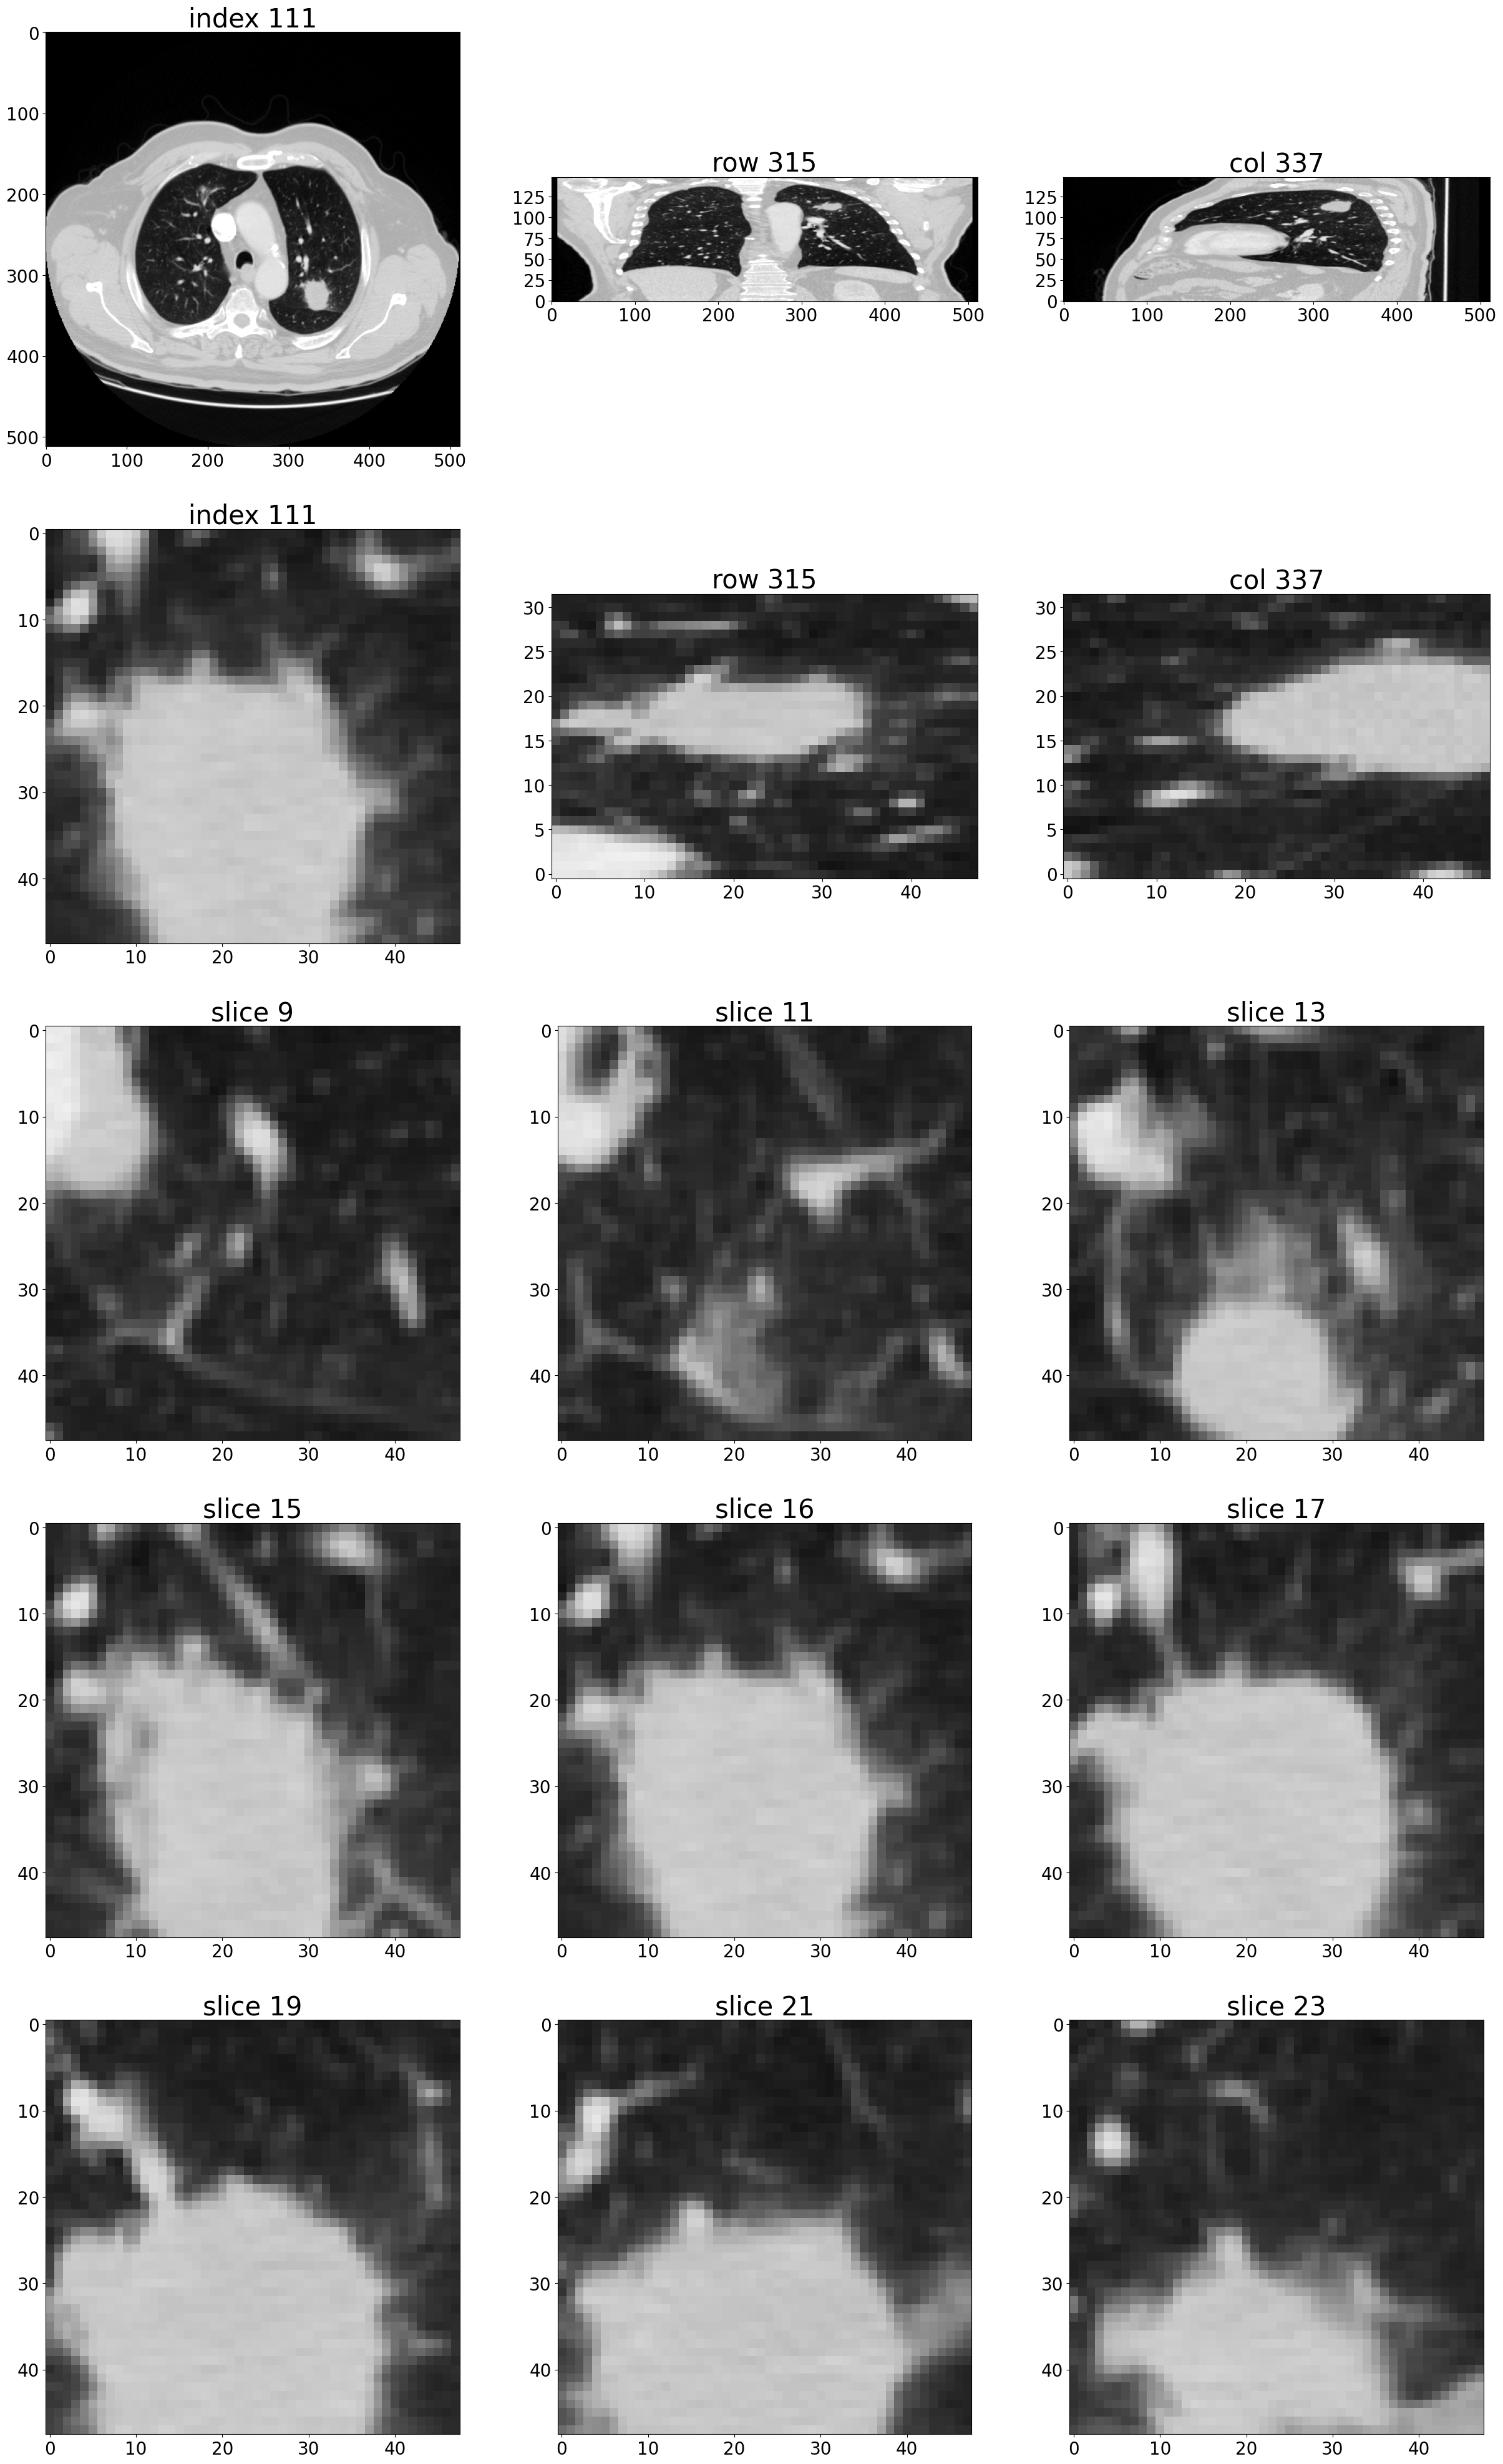

In [77]:
series_uid = positiveSample_list[11][2]
print(series_uid)
showCandidate(series_uid)